In [1]:
#IMPORTING LIBRARIES

import scipy.special as sp # UNUSED?
import numpy as np # NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more
import matplotlib.pyplot as plt # Provides a MATLAB-like way of plotting
import pandas as pd # Data analysis and manipulation tool. Used to read in bathymetry data (M77T file), Directions data (excel file), and organises Vmean into a labelled data structure
# M77T data files are created from raw data collected by marine researchers using InfoBank
from scipy.interpolate import CubicSpline as SP # Used to create a spline about the velocity, shape parameter and proability data
from scipy.optimize import minimize,least_squares,Bounds,basinhopping # Optimizing and route finding
from scipy.special import gamma # Gamma function used for weibull distribution
import matplotlib.cm as cm # UNUSED?
from Boruvka_Mod import Graph # imports class graph from Boruvka_Mod python file
import utm # Used to help convert latitude and longitude in bathymetry data to centred eastings and northings
import scipy.interpolate as spline # Used to smooth the bathymetry data
from matplotlib.colors import ListedColormap # UNUSED?
import math # Provides access to the mathematical functions
from time import perf_counter # Returns the float value of time in seconds. Used to record run time for clustering and optimization algorithms
from minmax_kmeans import minsize_kmeans # imports minsize_kmeans function from minmax_kmeans python file
import pulp #Used in the clustering algorithm to generate MPS and LP files

In [2]:
#READING IN BATHYMETRY DATA

data = pd.read_csv("nsea86.m77t", sep='\t') # Reads in all data from file including depth data, lattitude, longitude etc.
mindepth = min(data['CORR_DEPTH']) # Retrieves minimum depth value from data file 'nsea86.m77t'
print('Shallowest depth:', mindepth, 'm') #Prints out the result for the smallest depth value

Shallowest depth: 17.2 m


In [3]:
# KEY COSTING PARAMETERS USED THROUGHOUT MODEL

USDtoGBP = 1/1.38  #28th october 2021            #1/1.2821

IACableCostperMeter = 1000 # in GBP # Inter-array cable cost per metre (HVAC 33kV inter-array to substation)
HVACCableCostperMeter = 2500 # in GBP # Export cable cost per meter (HVAC 275kV substation to shore)
HVDCCableCostperMeter = 1100 # in GBP # Export cable cost per meter (VSC-HVDC 320kV substation to shore)

CostperTurbineUSD = 3000000 # USD
CostperTurbine = CostperTurbineUSD*USDtoGBP # GBP

OperatingandMaintenanceCostsperAnnum = 45000 # USD
LifeTimeTurbineOperatingTime = 20 # years 120000 # hours
MaintenanceCostperTurbine = OperatingandMaintenanceCostsperAnnum*USDtoGBP*LifeTimeTurbineOperatingTime # in GBP

LandCostperHectare = 17245 # in GBP
LandCostpermSquared = LandCostperHectare/10000 #  in GBP
FixedCost = 600000 # Costs  associated with the purchase and installation of electrical substations as well as thebuildings required for housing the staff and additional equipment required for the running of the wind farm.

In [4]:
#USER DEFINED VALUES

maximumturbinespertree = 10 # number of turbines allowed along a single cable from the substation.
budget = 100000000 # Budget in £ to build the wind farm, accounting for construction costs.

In [5]:
###CALCULATES THE INITIAL NUMBER OF TURBINES THE OPTIMISATION SHOULD START WITH.

maxnodespertree = maximumturbinespertree # As above

a = 350 # minimum distances turbines can be from one another in m.
b = 3000 # distance that turbines have negligible affect on eachother in m. If model changes this value could change
minareaperturbine = (1/2)*(math.sqrt(3))*(a**2) # Area per turbine assuming 350m between each turbine
LandCostperTurbine=minareaperturbine*(LandCostpermSquared) # Cost with minimum area
MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(mindepth)**2) - 0.0002*(float(mindepth)) + 0.9459)-CostperTurbine # Uses shallowest depth from before
print('Min depth cost per turbine = £',MinDepthCostPerTurbine) # prints result

MinCostperTurbTot = CostperTurbine+LandCostperTurbine+MaintenanceCostperTurbine+MinDepthCostPerTurbine # Total costs
nturb = (budget-FixedCost)/(MinCostperTurbTot)   #need to include depth cost
nturb = math.floor(nturb) # rounds down as cannot have fraction of a turbine
minarea = minareaperturbine*nturb # Overall minimum area considering the amount of turbines
maxarea = nturb*(1/2)*(math.sqrt(3))*(b**2) # Careful this isn't bigger than the entire size of the scaled nsea86 sea floor.

print('Min area per turbine =', minareaperturbine, 'm^2') # prints results
print('Min area =', minarea, 'm^2')
print('Max number of turbines =', nturb)
print('Max area =', maxarea, 'm^2')

Min depth cost per turbine = £ 3539.13043478271
Min area per turbine = 106088.11196359372 m^2
Min area = 3394819.582834999 m^2
Max number of turbines = 32
Max area = 249415316.2899183 m^2


In [6]:
#PRE-OPTIMISATION TURBINE POSITIONING

# places substation at (0,0).
# places 1st turbine at vector (a,0) from substation. a=350m from before
# places 2nd turbine at vector (0.5a,0.5aroot3) from prev. 
# places 3rd turbine at vector (-a,0) from prev
# places 4th turbine at vector (-a,0) from prev, continues in this spiralling fashion

positionlist = np.empty((nturb+1,2)) # Creates an empty list of size (number of turbines + 1 (since 0 position is substation),2)
turbineposition = np.array([[0,0]]) # Creates [0,0] array for introducing [x,y] coordinates for each turbine
positionlist[0,:] = turbineposition # 

oddcounter = 0
evencounter = 0
i = 0
k = 0

while k<nturb+1: # Loops for number of turbines 
    i += 1
    if (i%2)!= 0: # i is odd
        oddcounter+=1 
        for j in range(oddcounter):
            k += 1
            if k == nturb+1:
                break
            if (oddcounter%2)!= 0: #oddcounter is odd
                shift = np.array([[a, 0]])
            else:
                shift = np.array([[-a, 0]])
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
            
    else:
        evencounter+=1
        for j in range(evencounter):
            k += 1
            if k == nturb+1:
                break
            if (evencounter%2)!= 0: #evencounter is odd
                shift = np.array([[0.5*a,0.5*a*math.sqrt(3)]])
            else:
                shift = np.array([[-0.5*a,-0.5*a*math.sqrt(3)]]) 
            turbineposition = np.add(turbineposition, shift) 
            positionlist[k,:] = turbineposition
                
print(positionlist) # prints positions data        
print(len(positionlist)) # prints length of positions list (should be the number of turbines + 1 for the subsation)

[[    0.             0.        ]
 [  350.             0.        ]
 [  525.           303.10889132]
 [  175.           303.10889132]
 [ -175.           303.10889132]
 [ -350.             0.        ]
 [ -525.          -303.10889132]
 [ -175.          -303.10889132]
 [  175.          -303.10889132]
 [  525.          -303.10889132]
 [  700.             0.        ]
 [  875.           303.10889132]
 [ 1050.           606.21778265]
 [  700.           606.21778265]
 [  350.           606.21778265]
 [    0.           606.21778265]
 [ -350.           606.21778265]
 [ -525.           303.10889132]
 [ -700.             0.        ]
 [ -875.          -303.10889132]
 [-1050.          -606.21778265]
 [ -700.          -606.21778265]
 [ -350.          -606.21778265]
 [    0.          -606.21778265]
 [  350.          -606.21778265]
 [  700.          -606.21778265]
 [  875.          -303.10889132]
 [ 1050.             0.        ]
 [ 1225.           303.10889132]
 [ 1400.           606.21778265]
 [ 1575.  

In [7]:
# Shoreline implementation

minvalue = np.amin(positionlist, axis=0) #finds min value for each column of turbine positions
maxvalue = np.amax(positionlist, axis=0) #finds max value for each column of turbine positions
FurthestLeft = minvalue[0]
FurthestRight = maxvalue[0]

XShoreLine = np.array([np.linspace(FurthestLeft-1000,FurthestRight+1000,100)]) #Creates x coordinates of shoreline bewtween min and max turbine locations +/- 1000m
YShoreLine = np.array([np.linspace(-1500,-1500,100)]) #Cretaes y coordinates for shoreline at -1500
TXShoreLine = np.transpose(XShoreLine) #transpose of x coordinates
TYShoreLine = np.transpose(YShoreLine) #transpos of y coordinates
#ShoreLine = np.concatenate((XShoreLine,YShoreLine))
#TShoreLine = np.concatenate((TXShoreLine,TYShoreLine),axis=1)

(-2106.217782649107, 1409.3266739736605)

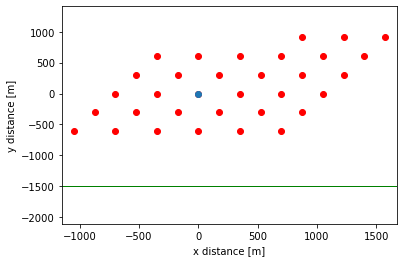

In [9]:
# Display pre-optimized turbine positions before clustering and MST

fig, ax = plt.subplots() #subplot ax created
ax.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax.scatter(0,0) # Substation
ax.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax.set_xlabel('x distance [m]') # x axis label
ax.set_ylabel('y distance [m]') # y axis label
ax.set_xlim([min(positionlist[:,0])-00, max(positionlist[:,0])+100])
ax.set_ylim([min(positionlist[:,1])-1500, max(positionlist[:,1])+500]) #limits adjusted to be able to see the shoreline

In [ ]:
#CLUSTERING ALGORITHM

#Uses an adapted version of kmeans with a cap on the number of points per cluster. Used to radially cluster turbines
#into segments which MST algorithm can then use to determine cabling for a given radial array. Initially unnecessary
#for the initially structured turbine layout as seen above, but increasingly important as turbine layout becomes
#non-uniform through optimisation when the below function is repeatedly called.
# minsize_kmeans imported from external python file

def clustering_algorithm(positionlist,nturb,maxnodespertree):
    k = math.ceil(nturb/maxnodespertree) #number of clusters. math.ceil rounds a number upwards to its nearest integer
    [turbines, centres] = minsize_kmeans(positionlist[1:,:] ,k ,min_size = 1, max_size = maxnodespertree) 
    #turbines exists as an array containing the cluster value for each turbine
    #Assigns each turbine to a cluster. excludes substation, executes external python file, 
    #limits for how many turbines are in each cluster between 1 and max nodes per tree 
    label = np.concatenate((np.array([-1]),turbines)) # Adds -1 (substation label) to the other turbine labels
    u_labels = np.unique(label) 
    # finds unique elements of label. Finds the unique cluster labels 
    # each turbine is assigned a cluster/label and this returns a single label for each cluster
    
    a = 0
    indiceslist = np.empty((k,maxnodespertree), dtype=np.int8) # empty array of no.clusters by max nodes per tree
# indiceslist basically tells us what turbines belong to each cluster
# each row of indiceslist represents a cluster and each point on that row a indidual turbine within that cluster
# Each row starts with a 0 which represents the subsation which belongs to all clusters
# As seen before in the initial layout numbers are assigned starting at 1 which is the turbine (a,0) from the substation
# The numbering then continues in a cyclic motion traveling anticlockwise up until the total number of turbines
    
    for i in range(k): # loops for number of clusters
        indices = [i for i, x in enumerate(label) if x == a] # enumerate exists as a counter in the loop (starts at x=a=0)

        if len(indices) < maxnodespertree:
            noofemptys = maxnodespertree - len(indices)
            for l in range(noofemptys): # For the empty spaces in the matrix replaces these with -100 as fillers
                indices.append(int(-100))
    
        indiceslist[i,:] = (indices)
        a += 1
    
    arr = np.zeros((k,1),dtype=np.int8)   # zero array of number of clusters by 1 (Substation array)
    indiceslist = np.concatenate((arr,indiceslist),axis=1) # Adds substation zero array to turbine cluster matrix
    return indiceslist,u_labels,label

t1_start = perf_counter() # Starts timer
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) #Executes clustering algorithm
t1_stop = perf_counter() # Ends timer
print('Function run time:', t1_stop-t1_start) # Prints algorithm run time

fig,ax = plt.subplots()
print(indiceslist)
for i in u_labels: # loops for number of turbines
    ax.scatter(positionlist[label == i , 0] , positionlist[label == i, 1] , label = i)
ax.legend() # prints legend
ax.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
plt.axis('equal') # Sets equal scaling for plot
ax.set_xlabel('x distance [m]') # x axis label
ax.set_ylabel('y distance [m]') # y axis label
plt.show() #shows plot

In [ ]:
#CREATES INPUT NEEDED FOR MST ONCE CLUSTERS ARE DEFINED.

def geom_analysis(positionlist,indiceslist):
    
    #Arrays for pairwise distances and angles
    #Angle 0: x directıon. Angle pi/2: y directıon
    distance = [None] * math.ceil(nturb/maxnodespertree) # null array with size based on number of clusters
    angle = [None] * math.ceil(nturb/maxnodespertree) 
    distance_global = np.zeros((nturb,nturb)) #zero array nturb by nturb. This will be for storing the distance between each pair of turbines for cabling
    angle_global = np.zeros((nturb,nturb)) # Like above this will be for storing the angle data between each pair of turbines for cabling
    coords = positionlist[1:,:] # Coordinates of each turbine

    for i in range(0,nturb): # loops for number of turbines
        distance_global[i,:]=np.sqrt(np.square(coords[i,0]-coords[:,0])+np.square(coords[i,1]-coords[:,1])) # Pythagoras for hypotenuse
        angle_global[i,:]=np.arctan2(coords[:,1]-coords[i,1],coords[:,0]-coords[i,0]) #Pythagoras for angle
        distance_global[i,i]=1e10
        #Rotate angles so that north=0 and convert to degrees
    angle_global=-np.rad2deg(angle_global)+270
    
    for x in range(0,math.ceil(nturb/maxnodespertree)): # loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1)
        distance[x]=np.zeros((nturbintree,nturbintree))
        angle[x]=np.zeros((nturbintree,nturbintree))
    
        for i in range(0,nturbintree):
            for j in range(0,nturbintree):
                distance[x][i,j] = np.sqrt(np.square(positionlist[(indiceslist[x,i]),0]-positionlist[(indiceslist[x,j]),0]) + np.square(positionlist[(indiceslist[x,i]),1]-positionlist[(indiceslist[x,j]),1]))
                angle[x][i,j]=np.arctan2(positionlist[(indiceslist[x,j]),1]-positionlist[(indiceslist[x,i]),1],positionlist[(indiceslist[x,j]),0]-positionlist[(indiceslist[x,i]),0])
                distance[x][i,i]=1e10
        
        #Rotate angles so that north=0 and convert to degrees
        angle[x]=-np.rad2deg(angle[x])+270
      
    return distance,angle,distance_global,angle_global

In [ ]:
# DETERMINES MINIMUM LENGTH OF CABLING REQUIRED TO CREATE COMPLETE CABLING NETWORK SUCH THAT ALL TURINES ARE CONNECTED
# IN ACCORDANCE WITH USER'S CONDITIONS.

def Minimum_Spanning_Tree(distance,indiceslist):

    MSTweight = [None] * math.ceil(nturb/maxnodespertree) # null array with sized based on number of clusters
   
    for x in range(0,math.ceil(nturb/maxnodespertree)): #loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1)
        g=Graph(nturbintree) #Graph is part of the external python script titled Boruvka_Mod
        
        for i in range(0,nturbintree):
            for j in range(i+1,nturbintree):
                g.addEdge(i,j ,(distance[x][i,j]*1000))
           
        MSTweight[x]=g.boruvkaMST()

    return MSTweight

In [ ]:
#PLOTTING PRE-OPTIMISED MST

# the Boruvka_mod code requires graphs with vertices 0....n, which is provided by the index value on indices list.
# When this is plotted, the values within the correct indiceslist row are then used to reference the index within
# positionlist to be plotted.

#

MSTweight=Minimum_Spanning_Tree(geom_analysis(positionlist, indiceslist)[0],indiceslist)

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
ax.scatter(positionlist[:,0],positionlist[:,1],c='red')
ax.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green

links = [None] * math.ceil(nturb/maxnodespertree)
MSTWeightSum = 0 #MST weight is simply the total length of cabling used

for a in range(0,math.ceil(nturb/maxnodespertree)):
    MSTWeightSum += MSTweight[a][0]
    print('Each tree weight', 'tree',a+1 ,MSTweight[a][0])
    links[a] = MSTweight[a][1]
    
    for b in links[a]:
        u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
        v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
        ax.plot(u,v, c='black')
        ax.scatter(0,0,c='blue')
        
print('MST total weight', MSTWeightSum, 'm')

In [ ]:
#DISPLAYS RAW BATHYMETRY DATA

print(data) # Prints out bathymetry data - Read in using pandas in previous section

In [ ]:
#CONVERTS LATITUDE AND LONGITUDE IN BATHYMETRY DATA TO CENTERED EASTINGS AND NORTHINGS

data['easting'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[0], axis=1) #Converts lon/lat to easting and adds this onto the 'data' file
data['northing'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[1], axis=1) #Converts lon/lat to northing and adds this onto the 'data' file

zero_east = min(data['easting']) + (max(data['easting']) - min(data['easting']))/2 +30000 # Determines centre of bathymrtry data in easting direction (+30,000 is simply to get a more interesting result from the current bathymetry data)
zero_north = min(data['northing']) + (max(data['northing']) - min(data['northing']))/2 # Determines centre of bathymetry data in northing direction   

data['centered_easting'] = data['easting'] - zero_east # Centres the data about (0,0) and adds this onto the 'data' file
data['centered_northing'] = data['northing'] - zero_north # Centres the data about (0,0) and adds this onto the 'data' file

print(data) 

In [ ]:
#PLOTS CENTERED BATHYMETRY DATA

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

In [ ]:
# SAMPLING AND PLOTTING CENTRAL BATHYMETRY DATA
# Takes sample between +/-120000 in easting direction, +/-90000 in the northing direction, and +/-1000 for the depth values

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data = data[(data['centered_easting'] >=-120000) & (data['centered_easting'] <= 120000) & (data['centered_northing']>=-90000) & (data['centered_northing']<= 90000) & (data['CORR_DEPTH']<=1000) & (data['CORR_DEPTH']>=-1000)]
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

In [ ]:
#FURTHER BATHYMETRY DATA PROCESSING
#Further decreases the area considered to be more applicable to the size of the wind farm (Sample from before divided by 10 in northing and easting directions)

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data['centered_easting'] = data['centered_easting']/10 
data['centered_northing'] = data['centered_northing']/10
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

In [ ]:
#UNSMOOTHED BATHYMETRY DATA CONTOUR PLOTTING

fig, ax = plt.subplots()
plt.xlim([-10000, 10000]) # x Limits of plot between +/-10000
plt.ylim([-7500, 7500]) # y Limits of plot between +/-7500
ax.set_aspect(aspect=1) # Sets the aspect of the axis scaling, i.e. the ratio of y-unit to x-unit.
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')

maxdepth = max(data['CORR_DEPTH'])
levels = np.linspace(mindepth,maxdepth,24) # Creates 24 even spaces or levels between the min and max depth

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], levels=levels, cmap = 'viridis_r') # (x,y,colour bar factor,level values,colour scale)
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Unsmoothed bathymetry data');

In [ ]:
#SMOOTHING BATHYMETRY DATA

smooth = spline.SmoothBivariateSpline(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], s = 25000)

fig, ax = plt.subplots()
plt.xlim([-10000, 10000])
plt.ylim([-7500, 7500])
ax.set_aspect(aspect=1)
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
levels = np.linspace(mindepth,maxdepth,24)

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Smoothed continuous bathymetry data');

In [ ]:
# DETERMINING DEPTH AND ASSOCIATED COST FOR EACH TURBINE

def depthvalues(positionlist):
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    DepthCostPerTurbine = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    DepthCostAllTurbines = 0 # Assigns initial value to variable

    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1]) # Acquires depth assigned to each turbines position (x,y)
        DepthCostPerTurbine[i] = MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(DepthPerTurbine[i])**2) - 0.0002*(float(DepthPerTurbine[i])) + 0.9459)-CostperTurbine #Formula for depth cost
        DepthCostAllTurbines += DepthCostPerTurbine[i] # Sums up all turbines depth costs
        
    mindepth=float(min(DepthPerTurbine))
    maxdepth=float(max(DepthPerTurbine))
    return DepthCostAllTurbines, mindepth, maxdepth # returns respective values to user

depthvalues(positionlist)

In [ ]:
#SETTING MODEL PARAMETERS

v0=8.0  #Incoming wind speed
nwind = 33
wind=np.arange(254,287)

#b=np.array((1,5,1000))
#b=np.array(( 1.40002561e-01,   8.51478121e+00,   2.62606729e+03))

# 3 model parameters below:

# 0th: how much power the turbine removes at the centre of the peak of the power distribution.
# 1st: how wide the angle of effect is. UNITS: degrees
# 2nd: up to how far back the effect takes place (approx. 2.6km) UNITS: [m]

model=np.array((1.39998719e-01, 8.51483871e+00, 2.62613638e+03))

ws=2.0 #weibull scale factor
wei_gamma=gamma(1.+1./ws)

Pr = 2*10**6 #Rated Power for Horns Rev 1 Turbines. Max power output [Watts]
Vc = 4.0 #Cut-in Velocity. Starts producing energy at wind speed of 4m/s [m/s]
Vr = 15.0 #Rated Velocity. Starts producing max energy at 15m/s
Vf = 25.0 #Cut-off Velocity. Turbines cut out at wind speeds of 25m/s to prevent damage to the turbines.
k = 2.0 #Weibull shape parameter
(Pr,Vc,Vr,k)

#interpolation parameters
dvel=1.5 #[m/s]
dang=5. #[degrees]

In [ ]:
#DETERMINING WIND DIRECTION AND VELOCITY AT HORNS REV 1

v=np.loadtxt('hornsrev_data_all.txt') # assigns data to variable v.
vxref=v[:,3] # (INDEXING STARTS FROM 0). Third column of data is velocity of wind in x direction.
vyref=v[:,4] # (INDEXING STARTS FROM 0). Fourth column of data is velocity of wind in y direction.
angles=v[:,0] # Zeroth column of data is wind angle.
vmean=np.sqrt(np.square(vxref)+np.square(vyref)) # Uses pythagoras to find the wind magnitude + direction for each location.

vmean=pd.DataFrame(vmean) # organises vmean into labelled data structure
vref=pd.DataFrame()

vmean['angle']=angles # add another column to vmean (angle)
vref=vref.append(vmean) # add empty pandas data frame

vref=vref.groupby('angle')
vref.groups
vref.describe()
vref.get_group(260).iat[50,0] # data manipulation to group by angle etc.

In [ ]:
#Arrays for pairwise distances and angles
#Angle 0: x direction. Angle pi/2: y directıon

# calculates distance and angle between each pair of turbines:

distance=np.zeros((nturb,nturb)) # 2x2 matrix of distances between turbines i and j where distance i-i and distance j-j = 0
# as they're distances to themselves: i-i i-j
                                 #    j-i j-j

angle=np.zeros((nturb,nturb)) # same as above but for angles between turbines.

for i in range(0,nturb):
   
    # 80x80 matrices as there's 80 turbines at Horns Rev 1.
    # squares y distance and x distance then sqrt to find overall distance between 2 turbines.
    distance[i,:]=np.sqrt(np.square(positionlist[i+1,0]-positionlist[1:,0])+np.square(positionlist[i+1,1]-positionlist[1:,1]))
    # same as above using arctan2 whilst giving correct quadrant (between 2 turbines).
    angle[i,:]=np.arctan2(positionlist[1:,1]-positionlist[i+1,1],positionlist[1:,0]-positionlist[i+1,0])
# Rotate angles so that north=0 and convert to degrees (and clockwise instead of anticlockwise)
angle=-np.rad2deg(angle)+270

# Rotating angles to wind direction
windangle=5 # degrees
rotangles=np.mod(angle-windangle+180,360)-180

In [ ]:
# IMPORTING WIND DIRECTION DATA

#meteorological data where north = 0 degrees)
directiondata = pd.read_csv ('Directiondata.csv')
print (directiondata)
# velocity is the mean velocity with which wind from this direction blows
# c determines how wide the distribution is
# frequency/100 determines how often the wind is blowing at this angle

In [ ]:
# interpolate 'velocity'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['Velocity']
wbvel = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360,0.10)
plt.plot(x,y, label='Line')
plt.plot(xs, wbvel(xs), label="Interpolated line ")
plt.title('Interpolated Velocity Data')
plt.xlabel('Angle')
plt.ylabel('Velocity')
plt.show()
# blue lines shows linear interpolation, orange shows smooth interpolation including across the
# periodic boundary.

In [ ]:
#interpolate 'c'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['c']
wbshape = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, wbshape(xs), label="S")
plt.title('Interpolated Shape Parameter Data')
plt.xlabel('Angle')
plt.ylabel('Shape Parameter')
plt.show()

In [ ]:
#interpolate 'frequency'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['frequency']/(100.*30.) #Data is in percent per 30 degrees, changing to probability per degree


windfreq = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, windfreq(xs), label="S")
plt.title('Interpolated Probability Data')
plt.xlabel('Angle')
plt.ylabel('Probability')
plt.show()
# plot shows wind direction is predominantly 200-320deg.

In [ ]:
# Simple Attenuation fn
# Determines how much wind there is AFTER a turbine.
def att(dist, ang, model): 
        # 'Model' parameters are defined in 2ND CELL.

    # angular part
    angular=np.where(2.*model[1]*np.abs(ang)<np.pi,np.square(np.cos(model[1]*ang)),0.)
    # angular = np.cos(model[1]*ang WHEN 2.*model[1]*np.abs(ang) is less than pi, else angular = 0.
    
    # radial part (distance) (Gaussian Function)
    radial=np.exp(-np.square(dist/model[2])) # decreasing exponential of square, scaled by 2nd parameter
    penalty=np.exp(-np.square(dist/200))
    #penalty = 0
    return 1.0-1*model[0]*angular*radial-2*model[0]*penalty # OUTCOME

In [ ]:
azimuths = np.radians(np.linspace(0, 360, 360)) # angles theta from 0 to 360 degress in 1 degree increments. Grid
zeniths = np.arange(0, 4000, 50) # distance from 0 to 4000 broken up into increments of 50.

r, theta = np.meshgrid(zeniths, azimuths)
values = att(r,np.mod(theta+np.pi,np.pi*2)-np.pi,model) # gets angles from -pi to pi, not from 0 to 2pi.

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, np.maximum(values,0.85*np.ones(np.shape(values))))

plt.show()
print(np.min(values))

## Cell description:
# Polar plot is for 1 turbine, blue area shows where wind speed is affected. (Numbers label distance from turbine).
# Across the curve the distribution is the hump of cosine^2 function.
# Radially the distribution shown is Gaussian.
# Wake is currently too narrow close to the turbine as it treats the turbine as a point rather than accommodating
# for the blades' diameter.

In [ ]:
# # isn't useful for continuing code, just rotates the windfarm.
# def rotate(angle,coords):
#     angle = np.pi*angle/180.
#     rotcoordx = []
#     rotcoordy = []
#     for coord in coords:
#         rotcoordx+=[coord[0]*np.cos(angle)-coord[1]*np.sin(angle)]
#         rotcoordy+=[coord[0]*np.sin(angle)+coord[1]*np.cos(angle)]
#     rotcoords=[rotcoordx,rotcoordy]
#     rotcoords=np.array(rotcoords).T   
#     return rotcoords 
# #print rotate(254,coords)[:,0]
# plt.scatter(rotate(0,coords)[:,0],rotate(0,coords)[:,1])

In [ ]:
# returning total deviation between model and training set (between CFD data and the attenuation model)
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation(b):
    total_att=np.ones((nturb,nwind))
    deviation=0
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]*att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,b)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            deviation=deviation+np.square(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return deviation

In [ ]:
# returning deviation for each turbine.
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation_sq(model):
    total_att=np.ones((nturb,nwind))
    dev_vec=np.zeros((nturb*nwind))
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,model)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            dev_vec[nturb*k+j]=(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return dev_vec

In [ ]:
# USEFUL OUTPUT USED IN TARGET FN
# Calculates the % of wind that arrives at a turbine for a certain angle.
# Starts with assumption that there's zero wake so all turbines get full wind.
#talked about
#Total att
def windspeedreduction(distance,angle,direction,model): # vectors
    ndir=np.size(direction)
    total_att=np.ones((nturb,ndir)) # as many rows as there are turbines, as many columns as there are wind directions.
 #   power_vec=np.zeros((nturb,ndir))
    for j in range(0,nturb):
        for i in range(0,nturb):
            if (i!=j):
                # compounding wind speed reductions
                total_att[j,:] = total_att[j,:]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-direction[:])+np.pi,np.pi*2)-np.pi,model)
  #      power_vec[j,:]=(v0*total_att[j,:])**3
    return total_att # matrix output that's needed. n turbine rows, n direction columns.
                     # Tells how much of 100% of wind arrives at a certain turbine from a certain direction.

In [ ]:
# USEFUL OUTPUT USED IN TARGET FN
# Calculates the power produced by turbines when it sees a certain wind speed at a certain angle. 3D matrix
def power(wsr,v): # wind speed reduction, velocity
    nvel=np.size(v)
    nangle=np.size(wsr,1)
    power_vec=np.zeros((nturb,nangle,nvel))
    power_vec=POvec(np.outer(wsr,v)).reshape(nturb,nangle,nvel) # np.outer takes every wsr element and individually multiplies it with every element of v.
    return power_vec

In [ ]:
#GIVES PROBABILITY OF WIND SPEED V AT A GIVEN ANGLE
def windspeedprobability(angles,v,d_angle,d_vel):
    nvel=np.size(v) 
    nangle=np.size(angles)
    wsprob=np.zeros((nangle,nvel))
    for i in range(angles.shape[0]):
        # Get Weibull parameters for angle and evaluate probability
        wsprob[i,:]=(wei(v[:],wbvel(angles[i]),wbshape(angles[i])))*windfreq(angles[i])*d_angle*d_vel
    return wsprob

In [ ]:
# DEFINES WEIBULL DISTRIBUTION (shows the probability of any given wind speed occuring).

def wei(x,n,k): # convention to have in this order, scale parameter comes first (x) 
    u=n/gamma(1+1/k) #scaled wind speed
    return (k / u) * (x / u)**(k - 1) * np.exp(-(x / u)**k)
# k = Weibull shape parameter
# n = scale parameter
# x= value we are valuating

In [ ]:
def wind_dist(v,vm):
    return wei(v,vm,k)

In [ ]:
wind_dist(1.0,v0)

In [ ]:
# PLOTS WEIBULL DISTRIBUTION

x=np.arange(0,25,0.1)
y=wind_dist(x,v0)

plt.xlabel('Wind Velocity')
plt.ylabel('Probability')
plt.plot(x,y)

In [ ]:
 velocities=np.arange(Vc,Vf,dvel) # 1D array ranging from Vc to Vf in dvel intervals. 4 to 25 in steps of 1.5
angles=np.arange(0,360,dang) # 0 to 360 with intervals of dang.
wsp=windspeedprobability(angles,velocities,dang,dvel) # tells probability of getting wind from a certain direction with a certain velocity.
# sum of all numbers would add up to 1.
print(wsp,np.shape(wsp),np.sum(wsp)) # wsp array, shape of wsp (rows,columns), sum of wsp elements
print(np.shape(velocities)) # shape of velocities array (rows, columns)
#plt.plot(x,y)

In [ ]:
# CALCULATES THE POWER CURVE OF A TURBINE

# Plots the power curve of a turbine.
# No power output from 0-4m/s, then cubic rise up to 15m/s and stays
# constant until cut-off velocity of 25m/s.

#cubic Based Power output
a=Pr/(Vr**3-Vc**3)
b=Vc**3/(Vr**3-Vc**3)

def q(v): # q is power output

    if (v<Vc): # below cut in velocity power is 0.
        q=0
    elif (v<Vr):
        q=a*v**3-b*Pr # cubic power output between cut in and max.
    elif (v<Vf):
        q=Pr # max power between max and cut off velocity.
    else: 
        q=0 # no power above cut off velocity.
    return q

In [ ]:
#PLOTS TURBINE POWER CURVE

x=np.arange(0,25,0.1)
POvec=np.vectorize(q) # vectorises power output function q (from cell above).
y=POvec(x)

plt.xlabel('Wind Velocity')
plt.ylabel('Power')
plt.plot(x,y)

In [ ]:
wsr=windspeedreduction(distance,angle,angles,model)
powout=power(wsr,velocities)

In [ ]:
# EXPECTED TURBINE OUTPUT (Watts) for the given wind distribution and positions.
# Can be seen that top left (NW) produces most energy for Horns Rev 1 Wind Farm.

# EXPECTED POWER FROM WIND FARM CALCULATIONS
# multiply the power that you'd get for each wind angle and speed condition by the probability of this occuring, for all angles and speed
# values and sum to find the expected power.
# Sum up this value for all turbines to find total wind farm expected power output.
output=np.zeros((nturb)) 
output=np.tensordot(powout,wsp,2)
print(output,np.shape(output),np.sum(output))
# last output is total power output in Watts.

In [ ]:
# TURBINE OUTPUT (Watts) WITH NO INTERFERENCE

#Reference output:
# Same calculations as cell above except each turbine sees the full amount of wind every time
# (i.e. no wind reduction from other turbines).
refpowout=power(np.ones((nturb,np.size(angles))),velocities)
refoutput=np.zeros((nturb))
refoutput=np.tensordot(refpowout,wsp,axes=2)
print(refoutput,np.shape(refoutput),np.sum(refoutput))

# last output is total power output in Watts.

In [ ]:
# # assigns smaller interpolation intervals to dvel and dang to compare to coarser interpolations.
# dvel=0.1
# dang=0.1
# velocities=np.arange(Vc,Vf+dvel,dvel)
# angles=np.arange(0,360,dang)
# wsp=windspeedprobability(angles,velocities,dang,dvel)
# wsr=windspeedreduction(distance,angle,angles,model)
# powout=power(wsr,velocities)
# output=np.zeros((nturb)) 
# output=np.tensordot(powout,wsp,2)
# print (dvel,dang,np.sum(output))
# fineout=output

In [ ]:
# # Calculates RMS error from changing interpolation value.
# velarray=np.array([1.5])
# angarray=np.array([5])
# rmserror=np.zeros((np.size(velarray),np.size(angarray)))
# i=0
# for dvel in velarray:
#     j=0
#     for dang in angarray:
#         velocities=np.arange(Vc,Vf+dvel,dvel)
#         angles=np.arange(0,360,dang)
#         wsp=windspeedprobability(angles,velocities,dang,dvel)
#         wsr=windspeedreduction(distance,angle,angles,model)
#         powout=power(wsr,velocities)
#         output=np.zeros((nturb)) 
#         output=np.tensordot(powout,wsp,2)
#         rmserror[i,j]=np.sqrt(np.sum(np.square(output-fineout))/np.size(output))
#         print (dvel,dang,np.sum(output),rmserror[i,j])
#         j+=1
#     i+=1
# print(rmserror)

In [ ]:
distance,angle,distance_global, angle_global = geom_analysis(positionlist,indiceslist)
wsr=windspeedreduction(distance_global,angle_global,angles,model)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)

In [ ]:
#PLOTTING FUNCTION

def plotting_function(positionlist,indiceslist,MSTweight,data):

    mindepth = (depthvalues(positionlist))[1]
    maxdepth = (depthvalues(positionlist))[2]

    nturb=np.size(positionlist,0)-1 # -1 due to the substation ar positonlist[0,:]
    links = [None] * math.ceil(nturb/maxnodespertree) # math.ceil rounds a number upwards to its nearest integer
    MSTWeightSum = 0

    fig, ax = plt.subplots()
    plt.axis('equal')
    ax.set_xlabel('x distance [m]')
    ax.set_ylabel('y distance [m]')
    ax.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100])
    ax.set_ylim([min(positionlist[:,1])-1500, max(positionlist[:,1])+500]) #limits adjusted to be able to see the shoreline

    for a in range(0,len(MSTweight)):
        MSTWeightSum += MSTweight[a][0]
        links[a] = MSTweight[a][1]
        for b in links[a]:
            u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
            v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
            plt.plot(u,v,c='black')

    CableCost=(MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal =(nturb)*CostperTurbine
    MaintenanceCosts=(nturb)*MaintenanceCostperTurbine # 1563720 lifetime maintenace cost per MW (*2 cus 2MW turbines)
    # FixedCost=600000###
    LandCost = (max(positionlist[:,0])-min(positionlist[:,0])) * (max(positionlist[:,1])-min(positionlist[:,1])) * (LandCostpermSquared)
    TotalCost=TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost### 
    
    print('Maximum turbines per MST:', maximumturbinespertree)
    print('Number of turbines:', nturb)
    print()
    print('Cabling Cost: £', CableCost)
    print('Depth Cost: £', DepthCostAll)
    print('Turbine Cost: £', TurbineCostTotal)
    print('Land Cost: £', LandCost)
    print('Maintenance Cost: £', MaintenanceCosts)
    print('Fixed Cost: £', FixedCost) 
    print()
    print('\033[1m'+'Budget: £'+'\033[0m', budget)
    print('\033[1m'+'Total Cost: £'+'\033[0m', TotalCost)
        
    levels = np.linspace(mindepth-3,maxdepth+3,24) # Change to min(smooth) and max(smooth) somehow

    tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
    cbar = plt.colorbar(tcf)
    cbar.set_label('Depth (m)')
    ax.set_title('Plot showing sea floor topography and turbines with cables');
    ax.scatter(positionlist[:,0],positionlist[:,1],c='red')
    ax.scatter(0,0,c='blue')
    ax.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
    
    PieChartLabels = ['(Inter-Array) Cabling Costs', 'Depth Costs', 'Turbine Costs', 'Land Costs', '(Life time) Maintenance Costs', 'Fixed Costs'] # Titles for each segment of pie chart
    sizes = [CableCost,DepthCostAll,TurbineCostTotal,LandCost,MaintenanceCosts,FixedCost] # Figures for each segment of pie chart
    
    fig, ax2 = plt.subplots()
    ax2.pie(sizes, labels=PieChartLabels, autopct='%1.1f%%') # Pie chart with brekadown of all associated costs
    ax2.axis('equal') #equal aspect ratio
    ax2.set_title('Wind Farm Costs') #Pie chart title
                                                                                                  
    return TotalCost

In [ ]:
#DISPLAYING PRE-OPTIMISED LAYOUT AND ASSOCIATED INFO

print('\033[1m'+'\033[4m'+'PRE-OPTIMISED LAYOUT INFORMATION'+'\033[0m'+'\033[0m')
print()
MSTweight = Minimum_Spanning_Tree(distance,indiceslist)
TotalCost = plotting_function(positionlist,indiceslist,MSTweight,data)
TPO = np.sum(output)
print('\033[1m'+'Total Power Output:'+'\033[0m', TPO, 'W')
print('\033[1m'+'Cost per Watt'+'\033[0m',TotalCost/TPO,'£/W')

In [ ]:
#REDUCING NO. OF TURBINES PRE-OPTIMISATION

overspend = TotalCost - budget
if overspend > 0:
    nturbstoremove = math.floor(overspend/(MinCostperTurbTot))
    ### It can be safely assumed that this many turbines at minimum can be removed.
    print('Number of removed turbines:', nturbstoremove)
    for amount in range(0,nturbstoremove):
        nturb = nturb - 1
        positionlist = np.delete(positionlist, len(positionlist)-1, 0)
    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)
    print('new number of turbines:', nturb)

In [ ]:
#TARGET FUNCTION

# analyses the coordinates to collate the distances and angles between all of them
# calculates the minimum spanning tree length and adds the assumption of cabling costs,
# turbines costs, maintenance costs and fixed costs.

smallestindiceslist = []
smallestTotalCost = None
smallestCostPerWatt = 10000000000000.0
smallestpositionlist = []

def targetfunction(coord_flat):
    
    #Global variables are used instead of res.x as res.x only holds the coordinates, not the other associated parameters,
    #inc. the optimal clustering, which will not necessarily be the same if the clustering algorithm is run again as the
    #start position is random for clustering. Additionally, res.x only provides an approximate minimization, whereas
    #storing values as global variables and finding the minimum guarantees that the minimum value found is returned.
    
    global smallestindiceslist
    global smallestTotalCost
    global smallestCostPerWatt
    global smallestpositionlist
    
    arr1 = np.zeros((1,2),dtype=float)
    arr2=np.reshape(coord_flat,(-1,2)) # undoes the coordinate flattening
    positionlist = np.concatenate((arr1,arr2),axis=0)
    
    nturb=np.size(positionlist,0)-1
    print('nturb', nturb)

    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)
    distance,angle,distance_global,angle_global = geom_analysis(positionlist,indiceslist)
    
    MSTweight=Minimum_Spanning_Tree(distance,indiceslist)
    MSTWeightSum=0
    
    for a in range(0,math.ceil(nturb/maxnodespertree)):
        MSTWeightSum += MSTweight[a][0]
    
    CableCost=(MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal=(nturb)*CostperTurbine
    MaintenanceCosts=(nturb)*MaintenanceCostperTurbine
    # FixedCost=600000
    LandCost = (max(positionlist[:,0])-min(positionlist[:,0])) * (max(positionlist[:,1])-min(positionlist[:,1])) * (LandCostpermSquared)
    TotalCost=TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost
    
    wsr=windspeedreduction(distance_global,angle_global,angles,model)
    powout=power(wsr,velocities) # total output power
    output=np.tensordot(powout,wsp,axes=2)
    
    print('Total power output in Watts', np.sum(output),'Total Cost in £', TotalCost, '£/W', (TotalCost/(np.sum(output))))###

    CostperWatt = TotalCost/(np.sum(output))
    
    if CostperWatt < smallestCostPerWatt:
        smallestCostPerWatt = CostperWatt
        smallestindiceslist = indiceslist
        smallestTotalCost = TotalCost
        smallestpositionlist = positionlist
    print('smallest cost per watt',smallestCostPerWatt)
    
    return CostperWatt

In [ ]:
# OPTIMIZATION

t1_start = perf_counter() # timer starts

while True:  
    
    flat_coords=positionlist[1:,:].flatten() # turns 2D coords into single list of data without any more structure.
    dvel=1.5
    dang=5
    velocities=np.arange(Vc,Vf,dvel)
    angles=np.arange(0,360,dang)

## COULD USE BASINHOPPING AND SET THE STEP SIZE

    res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, hess=None, options={'disp': 2, 'eps': 50})
     
    if smallestTotalCost<=budget:
        if not res.success:
            print(res.status, res.message)
        break
    else:
        nturb = nturb - 1
        smallestindiceslist = []
        smallestTotalCost = None
        smallestCostPerWatt = 10000000000000.0
        smallestpositionlist = []
        positionlist = np.delete(positionlist, len(positionlist)-1, 0)

        # CANNOT USE CALLBACK as this only returns targetfunction output and not the other variables that are needed too.
        
t1_stop = perf_counter() # timer ends
totaltime = t1_stop - t1_start # total run time in seconds
print('Total function time:', totaltime)

In [ ]:
#DEFINES OPTIMAL LAYOUT USING DATA TAKEN FROM OPTIMISATION

distance,angle,distance_global,angle_global = geom_analysis(smallestpositionlist,smallestindiceslist)
MSTweight = Minimum_Spanning_Tree(distance,smallestindiceslist)

In [ ]:
#DISPLAYS OPTIMAL LAYOUT

print('\033[1m'+'\033[4m'+'POST-OPTIMISED LAYOUT INFORMATION'+'\033[0m'+'\033[0m')
print()
plotting_function(smallestpositionlist,smallestindiceslist,MSTweight,data)
print('\033[1m'+'Total Power Output:'+'\033[0m', smallestTotalCost/smallestCostPerWatt, 'W')
print('\033[1m'+'Cost per Watt'+'\033[0m',smallestCostPerWatt,'£/W')

In [ ]:
# 8 turbines produce 6MW of output, which is 37.5% of their max output, which is roughly correct.
# If the wind speed decreases by half, power production decreases by a factor of eight.
# On average, therefore, wind turbines do not generate near their capacity.
# Industry estimates project an annual output of 30-40%, but real-world experience shows that
# annual outputs of 15-30% of capacity are more typical in a year. Therefore this improved 37.5% is good.